# エージェント 実行例

LCELによるエージェントは基本的にカスタマイズがしづらいことから、事前に定義された処理をimportしてそのまま使うような形となっています。  
LangGraphの方は、比較的柔軟にカスタムすることが前提となっていることから、ツール以外の定義もノートブック上で記載しています。  

どちらもそのまま使うというより参考用のもので、指示によりうまく動作しない可能性は十分にあります。  
そのような用途にはツールやプロンプト、フローを調整するなどで対応してください。  

モデルにはtemperature=0に加えてseedの指定もしていますが、1回の実行では結果が再現されないことがあります。  
複数回実行すればおそらく同じ結果を再現することができるはずです。  

## 準備

モデルが使えるよう、APIキーを用意しておいてください。  
モデルはTool-Callingに対応していれば動作するかと思いますが、2024/9時点ではOpenAI以外のサービスの場合はエラーになる場合があります。  

後半ではローカルのモデルを動かすのに[ollama](https://ollama.com/)を使用しています。  
クラウドのLLMに置き換えることもできますが、そのままであればモデルが動かせるようにしておいてください。

In [1]:
# Set environment variables for the API key
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## LCEL

pandasのエージェントを参考に作成したエージェントです。  
現在はエージェントの作成にはlanggraphが推奨になっていますが、必要とされる処理の参考として作成しました。  
agent_typeよりツールを切り替えていて、tool-callingの場合は最終結果をhtmlで出力しますが、対応していないモデルでzero-shot-react-descriptionで動かす場合はすべてlistingになります。  
基本はpandasのものをベースに、機能の追加などは基本的には行っていません。  

SASにあわせて以下のパラメータを設定しています。
> session_options: SASセッション用のオプション  
> lib_path: libname LIBRARY に割り当てるパス  

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    seed=1,
)

In [3]:
from agent.base import create_sas_dataset_agent 

agent_executor = create_sas_dataset_agent(
    llm,
    agent_type="tool-calling",
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_code=True,
    max_iterations=5
) 

Using SAS Config named: oda
SAS Connection established. Subprocess id is 25092



In [4]:
agent_executor.invoke({"input": "sashelp.classのオブザベーション数をproc sqlで出力してください。結果が10以上なら、数値変数をproc meansで要約したものをhtmlで出力してください。"})



> Entering new AgentExecutor chain...

Invoking: `sas_repl` with `{'query': 'proc sql; select count(*) as obs_count from sashelp.class; quit;', 'direct': False}`



The SAS System

obs_count
---------
       19

Invoking: `sas_repl` with `{'query': 'proc means data=sashelp.class; run;', 'direct': True}`




Variable,N,Mean,Std Dev,Minimum,Maximum
Age Height Weight,19 19 19,13.3157895 62.3368421 100.0263158,1.4926722 5.1270752 22.7739335,11.0000000 51.3000000 50.5000000,16.0000000 72.0000000 150.0000000


FINAL ANSWER.

> Finished chain.


{'input': 'sashelp.classのオブザベーション数をproc sqlで出力してください。結果が10以上なら、数値変数をproc meansで要約したものをhtmlで出力してください。',
 'output': 'FINAL ANSWER.',
 'intermediate_steps': [(ToolAgentAction(tool='sas_repl', tool_input={'query': 'proc sql; select count(*) as obs_count from sashelp.class; quit;', 'direct': False}, log="\nInvoking: `sas_repl` with `{'query': 'proc sql; select count(*) as obs_count from sashelp.class; quit;', 'direct': False}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_wM8k5MSIfjC8Htc1YbniY5zc', 'function': {'arguments': '{"query":"proc sql; select count(*) as obs_count from sashelp.class; quit;","direct":false}', 'name': 'sas_repl'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54e2f484be'}, id='run-aa710091-84d4-4b88-a8c5-9a78f44869c9', tool_calls=[{'name': 'sas_repl', 'args': {'query': 'proc sql; select count(*) as obs_count from sa

## Langgraph

### Toolとしての動作確認
はじめにツールのみを実行する、以下のような最低限のフローを定義して、ツールとしてStateを参照して正しく実行ができるか確認します。

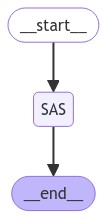

__State の定義__  
StateではMessagesに加えて、langgraphのContextを使用して、SASのセッションを管理します。

In [5]:
from contextlib import contextmanager
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableConfig
from langgraph.channels.context import Context
import saspy

class AgentContext(BaseModel):
    class Config:
        arbitrary_types_allowed = True

    sas: saspy.SASsession

@contextmanager
def make_agent_context(config: RunnableConfig):
    session_options = config.get('configurable', {}).get('session_options', {})

    sas = saspy.SASsession(**(session_options))
    try:
        yield AgentContext(sas=sas)
    finally:
        sas.endsas()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    context: Annotated[AgentContext, Context(make_agent_context)]

__ツールの読み込みとノード作成__

ツールを読み込みます。参照しているツールではStateを使用するように定義しています。

In [6]:
from tools.sas import SASReplState
from langgraph.prebuilt import ToolNode

tools = [SASReplState()]
tool_node = ToolNode(tools)

__フローの定義__  



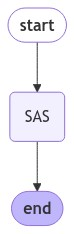

In [7]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node("SAS", tool_node)

workflow.add_edge(START, "SAS")
workflow.add_edge("SAS", END)

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

__フローの実行__

作成したツールのNodeはtool_callでの呼び出し用のため、messagesに必要な情報を入れて実行します。

In [8]:
from langchain_core.messages import AIMessage

inputs = {
    "messages": [AIMessage(content='',  tool_calls=[{'name': 'sas_repl', 'args': {'query': 'proc means data=sashelp.class; run;', 'direct':'True', 'instructions':''}, 'id': '1', 'type': 'tool_call'}] )]
    }


sas_options = { "autoexec": "options nodate nonumber nocenter locale=en_us;"}

for chunk in app.stream(inputs, stream_mode="values", config={"configurable": {"session_options":sas_options}}):
    chunk["messages"][-1].pretty_print()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 60868

================================== Ai Message ==================================
Tool Calls:
  sas_repl (1)
 Call ID: 1
  Args:
    query: proc means data=sashelp.class; run;
    direct: True
    instructions:


Variable,N,Mean,Std Dev,Minimum,Maximum
Age Height Weight,19 19 19,13.3157895 62.3368421 100.0263158,1.4926722 5.1270752 22.7739335,11.0000000 51.3000000 50.5000000,16.0000000 72.0000000 150.0000000


SAS Connection terminated. Subprocess id was 60868
================================= Tool Message =================================
Name: sas_repl

FINAL ANSWER.


## 実行例

生成AIを業務で利用できない理由の代表的なものに、情報やデータの管理上の規則やルールでクラウドのモデルで扱える内容が限られるということがあります。  
これに対して、ここでは以下のようなローカルのモデルも利用したフローを例として作成し、実行します。  

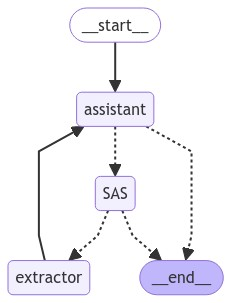

assistantはクラウドのモデルを想定し、高機能ではあるもののSASの実行結果にはアクセスさせたくありません。  
そのため、ローカルのモデルを想定したextracorを設定し、SASの実行結果はメッセージとは別に保持してextractorを介すことで、クラウドに直接送られないようにしています。  

実際には扱う内容や指示により意図したように動作しないことも想定されるので、データをより厳密・確実に扱う必要がある場合は、コードの実行結果を必ず最終出力にする、Human In The Loopでチェックを行うなどにより対応します。

ローカルのモデルの実行にはollama、モデルはphi3.5を使用しています。  
今回はローカルLLMはなるべく単純な動作に限定して、軽量なモデルを使用しています。  
配布されている状態では量子化によりファイルサイズが2GB程度と、スマートフォンでも動かせるようなレベルのため、一般的なPCであれば動くはずです。

In [9]:
from langchain_ollama import ChatOllama

local_llm = ChatOllama(
    model="phi3.5",
    temperature=0,
    seed=10,
)
 
from langchain_openai import ChatOpenAI

cloud_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    seed=1,
)

In [10]:
from contextlib import contextmanager
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableConfig
from langgraph.channels.context import Context
import operator
from typing import Annotated, Sequence, TypedDict

import saspy

class AgentContext(BaseModel):
    class Config:
        arbitrary_types_allowed = True

    sas: saspy.SASsession

@contextmanager
def make_agent_context(config: RunnableConfig):
    session_options = config.get('configurable', {}).get('session_options', {})

    sas = saspy.SASsession(**(session_options))
    try:
        yield AgentContext(sas=sas)
    finally:
        sas.endsas()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    context: Annotated[AgentContext, Context(make_agent_context)]

__使用するプロンプト__  

基本的にはチュートリアルのものを参考にしています。  
ローカルLLMはクラウドのものと性能が低くなることが多く、履歴を渡すとうまく処理されないようでした。   
そのためコードとあわせてコードの目的や説明を生成し、ローカルLLMに説明と結果のみを渡すようにしています。

In [11]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_assistant_agent(cloud_llm, tools):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | cloud_llm.bind_tools(tools, parallel_tool_calls=False)


def create_extractor_agent(local_llm):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                "You are receiving a result from tools, and expected to answer acording to the tool result and instructions."
                "Answer only the question asked, DO NOT provide any part of the results or additional information."
            ),
          ("human","instructions: {instructions}. result: {result}."),
        ]
    )
    return prompt | local_llm

In [12]:
import functools

from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

from tools.sas import SASReplState

# Helper function to create a node for a given agent
def create_agent_node(state, agent):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}))
    return {
        "messages": [result],

    }

def create_extractor_node(state, agent):
    messages = state["messages"]

    tool_call = messages[-2].tool_calls[0]["args"]
    output = messages[-1].artifact
    result = agent.invoke({"instructions":tool_call["instructions"], "result":output})

    result = AIMessage(**result.dict(exclude={"type", "name"}))
    return {
        "messages": [result],
    }


# SAS node
tools = [SASReplState()]

tool_node = ToolNode(tools)

# assistant node
assistant_agent = create_assistant_agent(
    cloud_llm,
    tools,
)
assistant_node = functools.partial(create_agent_node, agent=assistant_agent)

# extractor node
extractor_agent = create_extractor_agent(
    local_llm,
)

extractor_node = functools.partial(create_extractor_node, agent=extractor_agent)


__ルーティング用関数__


In [13]:
from typing import Literal

def router(state) -> Literal["SAS", "__end__" , "extractor"]:
    messages = state["messages"]
    last_message = messages[-1]

    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    if isinstance(last_message, ToolMessage):
            return "extractor"
    
    if last_message.tool_calls:
        return "SAS"
    
    return "__end__"

__フローの定義__  


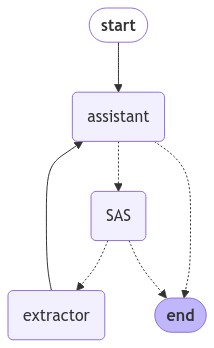

In [14]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(AgentState)

workflow.add_node("assistant", assistant_node)
workflow.add_node("SAS", tool_node)
workflow.add_node("extractor", extractor_node)

workflow.add_edge(START, "assistant")

workflow.add_conditional_edges(
    "assistant",
     router,
    {"SAS": "SAS", "__end__": END},
)

workflow.add_conditional_edges(
    "SAS",
     router,
    {"extractor": "extractor", "__end__": END},
)

workflow.add_edge("extractor", "assistant")

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

__実行__

LCELとの比較用に同じ内容に加えて、pandasエージェントとの比較にhead情報をクラウドのモデルに晒さないような例です。

In [15]:
inputs = {
    "messages": [HumanMessage(content="sashelp.classのオブザベーション数をproc sqlで出力してください。結果が10以上なら、数値変数をproc meansで要約したものをhtmlで出力してください。")]
    }

sas_options = { "autoexec": "options nodate nonumber nocenter locale=en_us;"}

for chunk in graph.stream(inputs, config= {"recursion_limit": 10, "configurable": {"session_options":sas_options}}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 19212

================================ Human Message =================================

sashelp.classのオブザベーション数をproc sqlで出力してください。結果が10以上なら、数値変数をproc meansで要約したものをhtmlで出力してください。
================================== Ai Message ==================================
Tool Calls:
  sas_repl (call_cCXHu1CrAFrSTBvDILR9QrAt)
 Call ID: call_cCXHu1CrAFrSTBvDILR9QrAt
  Args:
    query: proc sql; select count(*) as obs_count from sashelp.class; quit;
    direct: False
    instructions: Count the number of observations in sashelp.class.
================================= Tool Message =================================
Name: sas_repl

Got Listing Result.
================================== Ai Message ==================================

There are 19 observations in the dataset sashelp.class.
================================== Ai Message ==================================
Tool Calls:
  sas_repl (call_r9SMsLLcfCHwmk4knGiPXEO5)
 Call ID: 

Variable,N,Mean,Std Dev,Minimum,Maximum
Age Height Weight,19 19 19,13.3157895 62.3368421 100.0263158,1.4926722 5.1270752 22.7739335,11.0000000 51.3000000 50.5000000,16.0000000 72.0000000 150.0000000


SAS Connection terminated. Subprocess id was 19212
================================= Tool Message =================================
Name: sas_repl

FINAL ANSWER.


In [19]:
inputs = {
    "messages": [HumanMessage(content="sashelp.classの先頭5レコードの出力から性別が男子のデータを抽出するための条件を確認してください。その後その条件を使用して男子のレコードについて数値変数をproc meansで要約したものをhtmlで出力してください。")]
    }
sas_options = { "autoexec": "options nodate nonumber nocenter locale=en_us;"}
for chunk in graph.stream(inputs, config= {"recursion_limit": 10, "configurable": {"session_options":sas_options}}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 14204

================================ Human Message =================================

sashelp.classの先頭5レコードの出力から性別が男子のデータを抽出するための条件を確認してください。その後その条件を使用して男子のレコードについて数値変数をproc meansで要約したものをhtmlで出力してください。
================================== Ai Message ==================================
Tool Calls:
  sas_repl (call_PDo61a8cZWFKKVhDJxycsB6j)
 Call ID: call_PDo61a8cZWFKKVhDJxycsB6j
  Args:
    query: proc print data=sashelp.class (obs=5); run;
    direct: False
    instructions: Check the first 5 records of sashelp.class to identify the condition for filtering male records.
================================= Tool Message =================================
Name: sas_repl

Got Listing Result.
================================== Ai Message ==================================

Filter for male records where Sex is 'M'. The condition would be: WHERE Sex = 'M'
================================== Ai Message =======================

Variable,N,Mean,Std Dev,Minimum,Maximum
Age Height Weight,10 10 10,13.4000000 63.9100000 108.9500000,1.6465452 4.9379370 22.7271864,11.0000000 57.3000000 83.0000000,16.0000000 72.0000000 150.0000000


SAS Connection terminated. Subprocess id was 14204
================================= Tool Message =================================
Name: sas_repl

FINAL ANSWER.
